In [1]:
!pip install currencyconverter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.8/637.8 kB 12.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from currency_converter import CurrencyConverter, SINGLE_DAY_ECB_URL

# --- CONFIGURATION ---
INPUT_FILE = "watches_detailed2.jsonl"
OUTPUT_FILE = "watches_cleaned.csv"

# 1. Initialize the converter with the latest available rates
print("Downloading latest exchange rates...")
c = CurrencyConverter(SINGLE_DAY_ECB_URL)

# 2. Map the symbols found in scraping to ISO 4217 Codes
SYMBOL_TO_ISO = {
    '€': 'EUR',
    '£': 'GBP',
    '$': 'USD',
    '¥': 'JPY',
    'HK$': 'HKD',
    'CHF': 'CHF',
    'CA$': 'CAD',
    'AU$': 'AUD',
    'sg$': 'SGD',
    'DKK': 'DKK',
    'SEK': 'SEK'
}

def clean_price_and_currency(row):
    """
    Parses price string, detects symbol, maps to ISO,
    and converts to USD using the currency_converter library.
    """
    raw_price = str(row.get('Price', ''))

    # Filter bad data
    if not raw_price or "request" in raw_price.lower() or raw_price == 'nan':
        return np.nan, None

    # 1. Detect Currency ISO Code from Symbol
    iso_code = 'USD' # Default fallback
    found_symbol = None

    # Sort symbols by length (descending) so we match 'HK$' before '$'
    sorted_symbols = sorted(SYMBOL_TO_ISO.keys(), key=len, reverse=True)

    for symbol in sorted_symbols:
        if symbol in raw_price:
            found_symbol = symbol
            iso_code = SYMBOL_TO_ISO[symbol]
            break

    # 2. Clean the number (remove symbols, commas, spaces)
    # Keeps digits and decimal points
    clean_str = re.sub(r'[^\d.]', '', raw_price.replace(',', ''))

    try:
        amount = float(clean_str)

        # 3. Perform Conversion
        # If the code is already USD, it returns the amount unchanged
        # We use date=None to use the latest available rate in the downloaded zip
        price_in_usd = c.convert(amount, iso_code, 'USD')

        return round(price_in_usd, 2), iso_code

    except ValueError:
        # Could not parse number
        return np.nan, None
    except Exception as e:
        # Currency might not be in ECB list (rare for major currencies)
        print(f"Conversion error for {iso_code}: {e}")
        return np.nan, iso_code

def extract_size(val):
    if pd.isna(val): return np.nan
    val = str(val)
    match = re.search(r'(\d+(?:\.\d+)?)', val)
    if match:
        return float(match.group(1))
    return np.nan

def extract_year(val):
    if pd.isna(val): return np.nan
    val = str(val)
    match = re.search(r'\b(19|20)\d{2}\b', val)
    if match:
        return int(match.group(0))
    return np.nan

def main():
    print("Loading JSONL file...")
    df = pd.read_json(INPUT_FILE, lines=True)
    print(f"Raw shape: {df.shape}")

    # --- CLEAN PRICES WITH LIBRARY ---
    print("Converting Prices to USD...")
    price_data = df.apply(clean_price_and_currency, axis=1, result_type='expand')
    df['price_usd'] = price_data[0]
    df['original_currency'] = price_data[1]

    df = df.dropna(subset=['price_usd'])
    print(f"Rows after dropping missing prices: {df.shape[0]}")

    # --- CLEAN OTHER FEATURES ---
    print("Cleaning specs...")
    df['case_diameter_mm'] = df['Case diameter'].apply(extract_size)
    df['year_production'] = df['Year of production'].apply(extract_year)

    current_year = 2026
    df['watch_age'] = current_year - df['year_production']

    print("Imputing brands...")
    df['Brand'] = df['Brand'].fillna(df['Watch Name'].str.split().str[0])

    print("Engineering 'Scope of Delivery'...")
    df['scope_raw'] = df['Scope of delivery'].astype(str).str.lower()
    df['has_papers'] = df['scope_raw'].apply(lambda x: 1 if 'papers' in x else 0)
    df['has_box'] = df['scope_raw'].apply(lambda x: 1 if 'box' in x else 0)

    print("Cleaning Seller info...")
    df['seller_rating_clean'] = df['Seller rating'].apply(extract_size)
    df['seller_reviews_count'] = pd.to_numeric(df['Seller reviews'], errors='coerce').fillna(0)

    # Simplified condition text
    def clean_condition(val):
        if pd.isna(val): return "Unknown"
        match = re.search(r'\((.*?)\)', str(val))
        return match.group(1) if match else "Unknown"
    df['condition_clean'] = df['Condition'].apply(clean_condition)

    # --- SAVE ---
    final_columns = [
        'Brand', 'Model', 'Reference number', 'watch_age',
        'case_diameter_mm', 'Movement', 'Case material',
        'has_box', 'has_papers', 'condition_clean',
        'seller_rating_clean', 'seller_reviews_count', 'Seller type',
        'price_usd', 'original_currency', 'Link'
    ]

    cols_to_save = [c for c in final_columns if c in df.columns]
    final_df = df[cols_to_save]

    # Optional: Filter out rows with no brand/size data
    final_df = final_df.dropna(subset=['Brand', 'case_diameter_mm'])

    print(f"Final Cleaned Shape: {final_df.shape}")
    final_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved to {OUTPUT_FILE}")
    print("\n--- PREVIEW ---")
    print(final_df[['price_usd', 'original_currency', 'Brand']].head().to_string())

if __name__ == "__main__":
    main()

Loading JSONL file...
Raw shape: (99782, 2031)
Converting Prices to USD...
Rows after dropping missing prices: 98777
Cleaning specs...
Imputing brands...
Engineering 'Scope of Delivery'...
Cleaning Seller info...
Final Cleaned Shape: (87628, 16)
Saved to watches_cleaned.csv

--- PREVIEW ---
   price_usd original_currency            Brand
0    3775.52               EUR        TAG Heuer
1     325.00               USD  Maurice Lacroix
2     299.00               USD           Stauer
3   22999.00               USD  Audemars Piguet
4    2400.00               USD            NOMOS


In [1]:
!pip install xgboost scikit-learn matplotlib joblib catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder # <--- NEW LIBRARY
import joblib

INPUT_FILE = "watches_cleaned.csv"
BEST_MODEL_FILE = "best_watch_model_v2.pkl"

def load_data():
    print("Loading data...")
    df = pd.read_csv(INPUT_FILE)

    # 1. Filter Outliers
    df = df[(df['price_usd'] > 100) & (df['price_usd'] < 150000)]

    # 2. Fill Missing Values for Categorical Features
    # Target Encoder needs strings, not NaNs
    df['Model'] = df['Model'].fillna('Unknown')
    df['Reference number'] = df['Reference number'].fillna('Unknown')
    df['Brand'] = df['Brand'].fillna('Unknown')

    # 3. Define Features
    # We are now ADDING 'Model' and 'Reference number'
    features = [
        'Brand', 'Model', 'Reference number', # <--- The High Precision Features
        'case_diameter_mm', 'Movement',
        'Case material', 'condition_clean',
        'has_box', 'has_papers', 'watch_age',
        'seller_rating_clean', 'seller_reviews_count', 'Seller type'
    ]

    df = df.dropna(subset=features)

    X = df[features]
    y = np.log1p(df['price_usd'])

    return X, y

def get_preprocessor():
    # Group 1: High Cardinality (Thousands of categories) -> Use Target Encoding
    # This replaces "Submariner" with the average price of a Submariner.
    target_enc_features = ['Brand', 'Model', 'Reference number']

    # Group 2: Low Cardinality (Few categories) -> Use OneHot Encoding
    onehot_features = ['Movement', 'Case material', 'condition_clean', 'Seller type']

    return ColumnTransformer(
        transformers=[
            ('target', TargetEncoder(), target_enc_features),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features)
        ],
        remainder='passthrough'
    )

def train():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    preprocessor = get_preprocessor()

    # Using CatBoost as it usually handles this mix best,
    # but we wrap it in a pipeline to handle the encoding safely.
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(
            iterations=1500,
            learning_rate=0.05,
            depth=8,
            l2_leaf_reg=3,
            verbose=0,
            random_state=42
        ))
    ])

    print("\n--- TRAINING WITH MODEL & REF NUMBER ---")
    model.fit(X_train, y_train)

    # Evaluate
    preds_log = model.predict(X_test)
    preds_real = np.expm1(preds_log)
    y_test_real = np.expm1(y_test)

    r2 = r2_score(y_test_real, preds_real)
    mae = mean_absolute_error(y_test_real, preds_real)

    print(f"R² Score: {r2:.4f}")
    print(f"MAE: ${mae:,.2f}")

    if r2 > 0.85:
        print("🚀 Excellent! The model now understands specific watch models.")

    joblib.dump(model, BEST_MODEL_FILE)

if __name__ == "__main__":
    train()

Loading data...

Total Data: 41149
Train Size: 32919 | Test Size: 8230

--- TEST 1: Price Distribution ---
Train Mean Price: $13,337.39
Test Mean Price:  $13,406.80
Difference:       0.52%
✅ PASS: Average prices are very similar.
KS Statistic: 0.0127 (Lower is better)
P-Value:      0.2377
✅ PASS: The Price distributions are statistically identical.
📊 Plot saved to 'audit_price_distribution.png'

--- TEST 2: 'Unknown' Label Check ---
Unique Brands in Train: 131
Unique Brands in Test:  109
Brands in Test BUT NOT in Train: 6
⚠️ Examples of unseen brands: ['Bertolucci', 'Bruno Söhnle', 'Nivrel', 'Urwerk', 'Bovet']
   (These will cause errors or poor predictions for Ordinal/Target Encoders)

--- TEST 3: Brand Representation ---
Rolex % in Train: 34.10%
Rolex % in Test:  34.26%
✅ PASS: Rolex Representation is balanced.


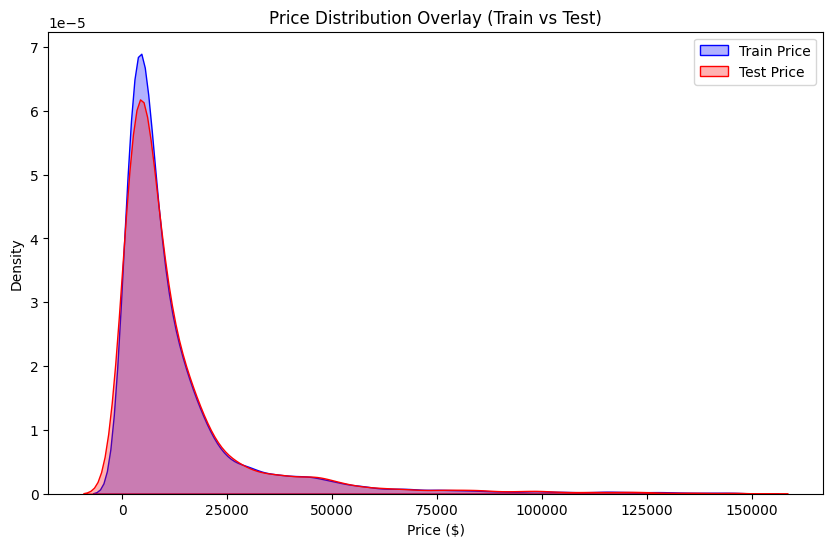

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

# --- CONFIGURATION ---
INPUT_FILE = "watches_cleaned.csv"

def analyze_split():
    print("Loading data...")
    df = pd.read_csv(INPUT_FILE)

    # Apply your specific filters (Must match your training script)
    df = df[(df['price_usd'] > 100) & (df['price_usd'] < 150000)]

    critical_cols = ['Brand', 'Model', 'Reference number', 'case_diameter_mm', 'watch_age']
    df = df.dropna(subset=critical_cols)

    X = df.drop(columns=['price_usd'])
    y = df['price_usd'] # Raw price (easier to visualize than log)

    # --- PERFORM THE SPLIT ---
    # We use the same seed (42) as your training script to reproduce the exact split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nTotal Data: {len(df)}")
    print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

    # ==========================================
    # TEST 1: PRICE DISTRIBUTION CHECK (Crucial)
    # ==========================================
    print("\n--- TEST 1: Price Distribution ---")

    train_mean = y_train.mean()
    test_mean = y_test.mean()
    diff = abs(train_mean - test_mean) / train_mean * 100

    print(f"Train Mean Price: ${train_mean:,.2f}")
    print(f"Test Mean Price:  ${test_mean:,.2f}")
    print(f"Difference:       {diff:.2f}%")

    if diff < 5:
        print("✅ PASS: Average prices are very similar.")
    else:
        print("⚠️ WARNING: Significant price difference between sets.")

    # KS Test (Kolmogorov-Smirnov)
    # Checks if two samples come from the same distribution.
    # P-value > 0.05 means "They are likely the same distribution"
    ks_stat, p_value = ks_2samp(y_train, y_test)
    print(f"KS Statistic: {ks_stat:.4f} (Lower is better)")
    print(f"P-Value:      {p_value:.4f}")

    if p_value > 0.05:
        print("✅ PASS: The Price distributions are statistically identical.")
    else:
        print("⚠️ WARNING: The distributions look statistically different (Try Stratified Split).")

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.kdeplot(y_train, label='Train Price', fill=True, alpha=0.3, color='blue')
    sns.kdeplot(y_test, label='Test Price', fill=True, alpha=0.3, color='red')
    plt.title("Price Distribution Overlay (Train vs Test)")
    plt.xlabel("Price ($)")
    plt.legend()
    plt.savefig("audit_price_distribution.png")
    print("📊 Plot saved to 'audit_price_distribution.png'")

    # ==========================================
    # TEST 2: CATEGORICAL LEAKAGE (Cold Start)
    # ==========================================
    print("\n--- TEST 2: 'Unknown' Label Check ---")
    # Does the Test set contain Brands or Models that Train never saw?

    train_brands = set(X_train['Brand'].unique())
    test_brands = set(X_test['Brand'].unique())

    unseen_brands = test_brands - train_brands

    print(f"Unique Brands in Train: {len(train_brands)}")
    print(f"Unique Brands in Test:  {len(test_brands)}")
    print(f"Brands in Test BUT NOT in Train: {len(unseen_brands)}")

    if len(unseen_brands) > 0:
        print(f"⚠️ Examples of unseen brands: {list(unseen_brands)[:5]}")
        print("   (These will cause errors or poor predictions for Ordinal/Target Encoders)")
    else:
        print("✅ PASS: All brands in Test exist in Train.")

    # ==========================================
    # TEST 3: STRATIFICATION CHECK (Brand)
    # ==========================================
    print("\n--- TEST 3: Brand Representation ---")
    # Check if the top brand (Rolex) is equally represented

    train_rolex_pct = (X_train['Brand'] == 'Rolex').mean() * 100
    test_rolex_pct = (X_test['Brand'] == 'Rolex').mean() * 100

    print(f"Rolex % in Train: {train_rolex_pct:.2f}%")
    print(f"Rolex % in Test:  {test_rolex_pct:.2f}%")

    if abs(train_rolex_pct - test_rolex_pct) < 2:
        print("✅ PASS: Rolex Representation is balanced.")
    else:
        print("⚠️ WARNING: One set has significantly more Rolexes than the other.")

if __name__ == "__main__":
    analyze_split()

Streaming output truncated to the last 5000 lines.
1036:	learn: 0.2033592	total: 30s	remaining: 27.9s
1037:	learn: 0.2033192	total: 30.1s	remaining: 27.9s
1038:	learn: 0.2032422	total: 30.1s	remaining: 27.8s
1039:	learn: 0.2031409	total: 30.1s	remaining: 27.8s
1040:	learn: 0.2030075	total: 30.1s	remaining: 27.8s
1041:	learn: 0.2029380	total: 30.2s	remaining: 27.7s
1042:	learn: 0.2028806	total: 30.2s	remaining: 27.7s
1043:	learn: 0.2028218	total: 30.2s	remaining: 27.7s
1044:	learn: 0.2027443	total: 30.2s	remaining: 27.6s
1045:	learn: 0.2026728	total: 30.3s	remaining: 27.6s
1046:	learn: 0.2025949	total: 30.3s	remaining: 27.6s
1047:	learn: 0.2025316	total: 30.3s	remaining: 27.5s
1048:	learn: 0.2024895	total: 30.4s	remaining: 27.5s
1049:	learn: 0.2024160	total: 30.4s	remaining: 27.5s
1050:	learn: 0.2023154	total: 30.4s	remaining: 27.4s
1051:	learn: 0.2022530	total: 30.4s	remaining: 27.4s
1052:	learn: 0.2021716	total: 30.4s	remaining: 27.4s
1053:	learn: 0.2021079	total: 30.5s	remaining: 27.

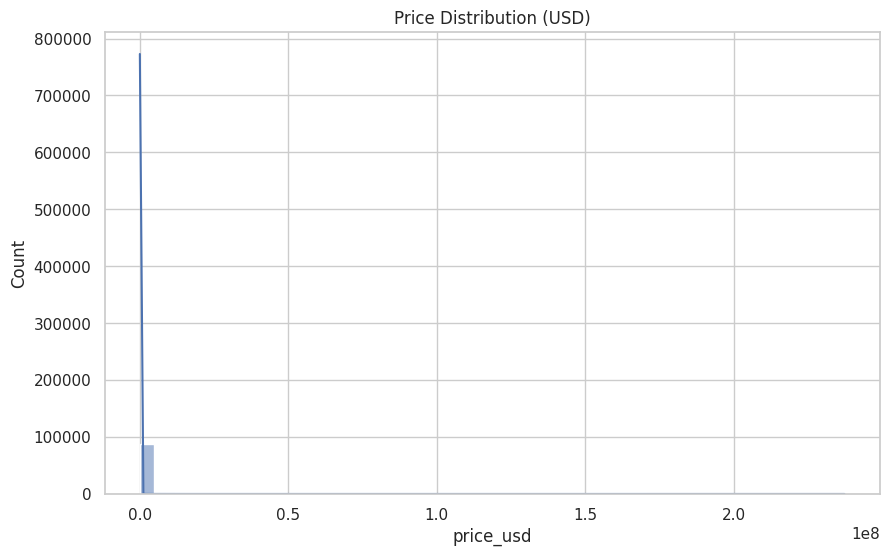

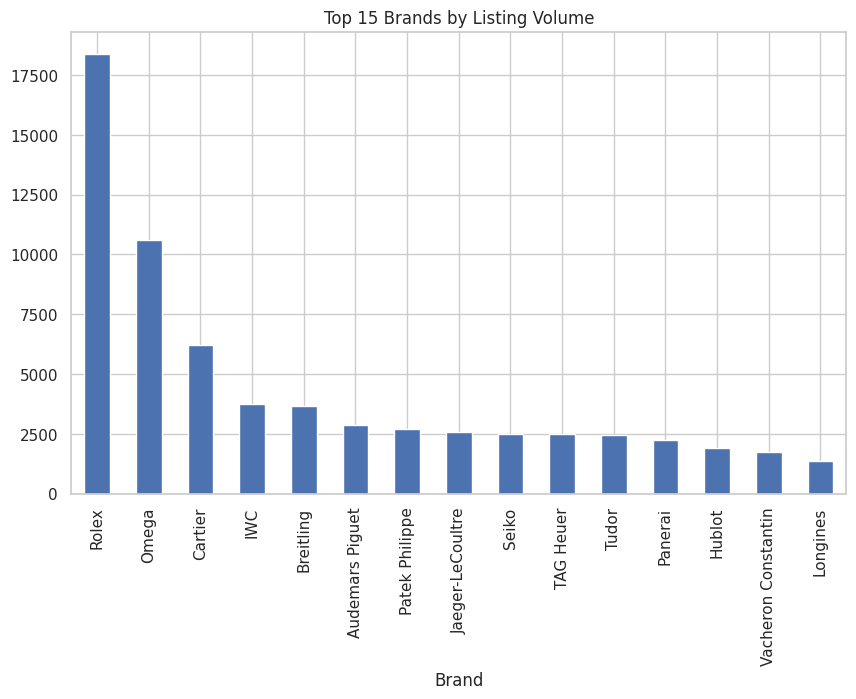

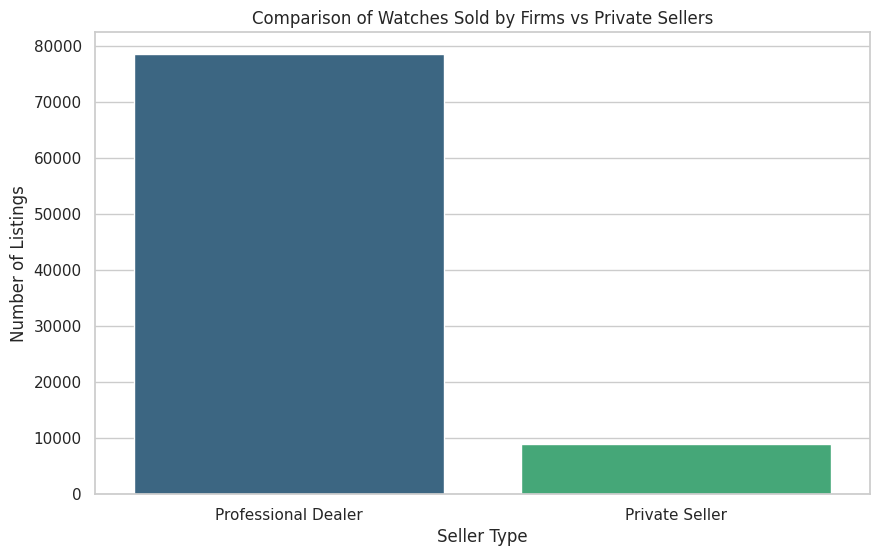

In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge
import joblib
import warnings
import datetime
import os

# Suppress warnings
warnings.filterwarnings('ignore')

INPUT_FILE = "watches_cleaned.csv"
LOG_FILE = f"experiment_log_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
RESULTS_FILE = f"model_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

# Global list to accumulate ALL results
ALL_RESULTS = []

def log(message):
    print(message)
    with open(LOG_FILE, "a") as f:
        f.write(message + "\n")

def add_results(results_list):
    """Add results to the global accumulator."""
    global ALL_RESULTS
    ALL_RESULTS.extend(results_list)

def save_all_results():
    """Save all accumulated model results to CSV."""
    if ALL_RESULTS:
        results_df = pd.DataFrame(ALL_RESULTS)
        results_df.to_csv(RESULTS_FILE, index=False)
        log(f"\n{'='*50}")
        log(f"All model results saved to {RESULTS_FILE}")
        log(f"Total configurations tracked: {len(ALL_RESULTS)}")
        log(f"{'='*50}\n")

def perform_eda(df):
    log("--- Starting Exploratory Data Analysis ---")
    os.makedirs('plots', exist_ok=True)

    # Add seller categorization for visualization
    df['Seller_Category'] = df['Seller type'].apply(categorize_seller)

    # 1. Price Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price_usd'], bins=50, kde=True)
    plt.title('Price Distribution (USD)')
    plt.savefig('plots/price_dist.png')

    # 2. Top Brands
    plt.figure(figsize=(10, 6))
    df['Brand'].value_counts().head(15).plot(kind='bar')
    plt.title('Top 15 Brands by Listing Volume')
    plt.savefig('plots/top_brands.png')

    # 3. Seller Category Distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Seller_Category', palette='viridis')
    plt.title('Comparison of Watches Sold by Firms vs Private Sellers')
    plt.ylabel('Number of Listings')
    plt.xlabel('Seller Type')
    plt.savefig('plots/seller_distribution.png')

    log(f"EDA complete. Plots saved to /plots directory. Data Shape: {df.shape}")

def categorize_seller(x):
    """Categorize seller type into Private Seller or Professional Dealer."""
    if 'private' in str(x).lower():
        return 'Private Seller'
    else:
        return 'Professional Dealer'

def load_and_prep_data():
    log("Loading and cleaning data...")
    df = pd.read_csv(INPUT_FILE)

    # FILTER: Target segment
    df = df[(df['price_usd'] >= 1000) & (df['price_usd'] < 20000)]

    # DROP MISSING
    critical_cols = ['Brand', 'Model', 'Reference number', 'case_diameter_mm', 'watch_age']
    df = df.dropna(subset=critical_cols)

    # Engineering Features
    df['Brand_Material'] = df['Brand'].astype(str) + "_" + df['Case material'].astype(str)
    df['ref_count'] = df.groupby('Reference number')['Reference number'].transform('count')
    df['Seller_Category'] = df['Seller type'].apply(categorize_seller)

    feature_cols = [
        'Brand', 'Model', 'Reference number', 'watch_age', 'case_diameter_mm',
        'Movement', 'Case material', 'condition_clean', 'Seller type', 'Seller_Category',
        'has_box', 'has_papers', 'ref_count', 'Brand_Material'
    ]

    X = df[feature_cols]
    y = df['price_usd']

    # Handle Categorical
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols].astype(str))

    return X, y, encoder

def get_best_models(X, y):
    """Performs hyperparameter tuning for all 4 base models."""
    log("\n--- Starting Hyperparameter Tuning ---")

    # Define search spaces
    model_configs = {
        "RandomForest": {
            "model": RandomForestRegressor(n_jobs=-1, random_state=42),
            "params": {
                "n_estimators": [100, 300],
                "max_depth": [10, 20, None],
                "min_samples_leaf": [1, 4]
            }
        },
        "LightGBM": {
            "model": lgb.LGBMRegressor(device="gpu", random_state=42, verbose=-1),
            "params": {
                "n_estimators": [1000, 3000],
                "learning_rate": [0.01, 0.05],
                "num_leaves": [31, 127]
            }
        },
        "XGBoost": {
            "model": xgb.XGBRegressor(device="cuda", random_state=42),
            "params": {
                "n_estimators": [1000, 3000],
                "learning_rate": [0.01, 0.05],
                "max_depth": [6, 10]
            }
        },
        "CatBoost": {
            "model": CatBoostRegressor(task_type="GPU", verbose=0, random_state=42),
            "params": {
                "iterations": [1000, 2000],
                "depth": [6, 10],
                "learning_rate": [0.01, 0.05]
            }
        }
    }

    tuned_models = {}
    hyperparams_results = []

    for name, config in model_configs.items():
        log(f"Tuning {name}...")
        search = RandomizedSearchCV(
            config["model"], config["params"],
            n_iter=5, cv=3, scoring='neg_mean_absolute_error', n_jobs=1,
            return_train_score=False
        )
        search.fit(X, y)
        tuned_models[name] = search.best_estimator_
        log(f"   Best Params: {search.best_params_}")
        log(f"   Best CV Score (MAE): ${-search.best_score_:.2f}")

        # For each configuration, manually compute R² and MAPE using cross-validation
        for i, params in enumerate(search.cv_results_['params']):
            # Clone model with these specific params
            model_clone = config["model"].__class__(**params)
            if hasattr(model_clone, 'random_state'):
                model_clone.random_state = 42
            if hasattr(model_clone, 'verbose'):
                if name == "LightGBM":
                    model_clone.verbose = -1
                elif name == "CatBoost":
                    model_clone.verbose = 0
            if hasattr(model_clone, 'device'):
                model_clone.device = "gpu" if name == "LightGBM" else "cuda"
            if hasattr(model_clone, 'task_type'):
                model_clone.task_type = "GPU"
            if hasattr(model_clone, 'n_jobs'):
                model_clone.n_jobs = -1

            # Get cross-validated predictions
            cv_preds_log = cross_val_predict(model_clone, X, y, cv=3)

            # Convert back to original scale
            y_true = np.expm1(y)
            y_pred = np.expm1(cv_preds_log)

            # Compute all metrics
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred) * 100

            hyperparams_results.append({
                'model_name': name,
                'configuration_id': i + 1,
                'params': str(params),
                'mean_cv_mae': round(mae, 2),
                'mean_cv_r2': round(r2, 4),
                'mean_cv_mape_percent': round(mape, 2),
                'is_best': params == search.best_params_,
                'stage': 'hyperparameter_tuning'
            })

            log(f"   Config {i+1}: MAE=${mae:.2f}, R²={r2:.4f}, MAPE={mape:.2f}%")

    add_results(hyperparams_results)
    log(f"Tracked {len(hyperparams_results)} hyperparameter configurations")
    return tuned_models

def train_stacking_pipeline():
    X, y, encoder = load_and_prep_data()
    y_log = np.log1p(y)

    # Initial Split: Holdout set for final evaluation
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y_log, test_size=0.15, random_state=42
    )

    # 1. Get Tuned Models
    base_models = get_best_models(X_train_full, y_train_full)

    # 2. Out-of-Fold (OOF) Predictions
    log("\n--- Generating Out-of-Fold Predictions (5-Fold CV) ---")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Dataframes to store predictions for the meta-model
    oof_train = pd.DataFrame(index=X_train_full.index)
    oof_test = pd.DataFrame(index=X_test.index)

    # Store base model CV results
    base_model_results = []

    for name, model in base_models.items():
        log(f"Processing OOF for {name}...")
        oof_preds = np.zeros(len(X_train_full))
        test_preds = []

        # Track each fold's performance
        fold_results = []

        for fold_num, (train_idx, val_idx) in enumerate(kf.split(X_train_full), 1):
            # Split
            X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
            y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

            # Fit & Predict
            model.fit(X_tr, y_tr)
            val_preds = model.predict(X_val)
            oof_preds[val_idx] = val_preds
            test_preds.append(model.predict(X_test))

            # Calculate fold metrics
            fold_mae = mean_absolute_error(np.expm1(y_val), np.expm1(val_preds))
            fold_r2 = r2_score(np.expm1(y_val), np.expm1(val_preds))
            fold_mape = mean_absolute_percentage_error(np.expm1(y_val), np.expm1(val_preds)) * 100

            fold_results.append({
                'model_name': name,
                'fold': fold_num,
                'mae_usd': round(fold_mae, 2),
                'r2_score': round(fold_r2, 4),
                'mape_percent': round(fold_mape, 2),
                'n_samples_train': len(train_idx),
                'n_samples_val': len(val_idx),
                'stage': 'cross_validation_fold'
            })

        oof_train[name] = oof_preds
        oof_test[name] = np.mean(test_preds, axis=0)

        # Internal Evaluation (overall CV performance)
        cv_mae = mean_absolute_error(np.expm1(y_train_full), np.expm1(oof_preds))
        cv_r2 = r2_score(np.expm1(y_train_full), np.expm1(oof_preds))
        cv_mape = mean_absolute_percentage_error(np.expm1(y_train_full), np.expm1(oof_preds)) * 100

        log(f"   {name} CV MAE: ${cv_mae:.2f}, R²: {cv_r2:.4f}, MAPE: {cv_mape:.2f}%")

        # Record overall CV results
        base_model_results.append({
            'model_name': name,
            'cv_mae_usd': round(cv_mae, 2),
            'cv_r2_score': round(cv_r2, 4),
            'cv_mape_percent': round(cv_mape, 2),
            'stage': 'base_model_cv_overall'
        })

        # Add fold-level results
        add_results(fold_results)

    add_results(base_model_results)
    log(f"Tracked {len(base_model_results)} base model CV results and {5 * len(base_models)} fold-level results")

    # 2.5. Evaluate each base model on holdout test set
    log("\n--- Evaluating Individual Base Models on Holdout Test Set ---")
    base_model_test_results = []

    for name, model in base_models.items():
        # Retrain on full training set
        model.fit(X_train_full, y_train_full)

        # Predict on test set
        test_preds_log = model.predict(X_test)
        y_test_real = np.expm1(y_test)
        test_preds_real = np.expm1(test_preds_log)

        # Calculate metrics
        test_mae = mean_absolute_error(y_test_real, test_preds_real)
        test_r2 = r2_score(y_test_real, test_preds_real)
        test_mape = mean_absolute_percentage_error(y_test_real, test_preds_real) * 100

        log(f"   {name} Test MAE: ${test_mae:.2f}, R²: {test_r2:.4f}, MAPE: {test_mape:.2f}%")

        base_model_test_results.append({
            'model_name': name,
            'test_mae_usd': round(test_mae, 2),
            'test_r2_score': round(test_r2, 4),
            'test_mape_percent': round(test_mape, 2),
            'n_test_samples': len(y_test),
            'stage': 'base_model_holdout_test'
        })

    add_results(base_model_test_results)
    log(f"Tracked {len(base_model_test_results)} base model test results")

    # 3. Meta-Model Training
    log("\n--- Training Meta-Model (Ridge Regression) ---")
    meta_model = Ridge(alpha=1.0)
    meta_model.fit(oof_train, y_train_full)

    # Record meta-model coefficients (how much weight each base model gets)
    meta_weights = []
    for i, col in enumerate(oof_train.columns):
        meta_weights.append({
            'model_name': 'Ridge Meta-Model',
            'base_model': col,
            'coefficient': round(meta_model.coef_[i], 4),
            'stage': 'meta_model_weights'
        })
    add_results(meta_weights)

    # 4. Final Evaluation on Holdout
    final_preds_log = meta_model.predict(oof_test)
    y_test_real = np.expm1(y_test)
    final_preds_real = np.expm1(final_preds_log)

    r2 = r2_score(y_test_real, final_preds_real)
    mae = mean_absolute_error(y_test_real, final_preds_real)
    mape = mean_absolute_percentage_error(y_test_real, final_preds_real) * 100

    log("\n" + "="*30)
    log("FINAL STACKED ENSEMBLE RESULTS")
    log(f"   R²:   {r2:.4f}")
    log(f"   MAE:  ${mae:,.2f}")
    log(f"   MAPE: {mape:.2f}%")
    log("="*30)

    # Record final ensemble results
    ensemble_results = [{
        'model_name': 'Stacked Ensemble (Ridge Meta-Model)',
        'r2_score': round(r2, 4),
        'mae_usd': round(mae, 2),
        'mape_percent': round(mape, 2),
        'n_test_samples': len(y_test),
        'stage': 'final_ensemble_holdout'
    }]
    add_results(ensemble_results)

    # 5. Save Artifacts
    joblib.dump(meta_model, "meta_model.pkl")
    joblib.dump(encoder, "encoder.pkl")
    log("Models and encoders saved.")

    # Save ALL results to CSV
    save_all_results()

if __name__ == "__main__":
    # Create an EDA snippet
    raw_df = pd.read_csv(INPUT_FILE)
    perform_eda(raw_df)

    # Run Pipeline
    train_stacking_pipeline()

--- Starting EDA Report: Data contains 35878 samples and 19 features ---
EDA Complete. All plots are in the 'watch_eda_report' folder.

--- Summary Statistics ---
       price_usd  case_diameter_mm  watch_age
count   35878.00          35878.00   35878.00
mean     9577.35             38.48      20.01
std      8015.67             46.84      18.22
min      1000.00              0.00      -3.00
25%      3942.02             36.00       6.00
50%      6826.83             40.00      14.00
75%     12815.72             42.00      28.00
max     39999.00           4425.00     121.00


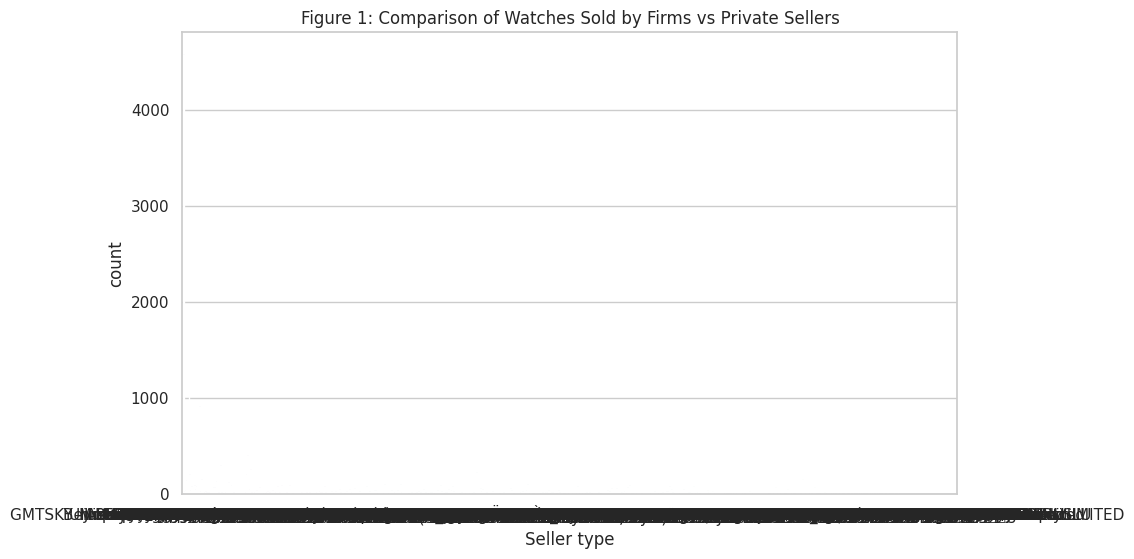

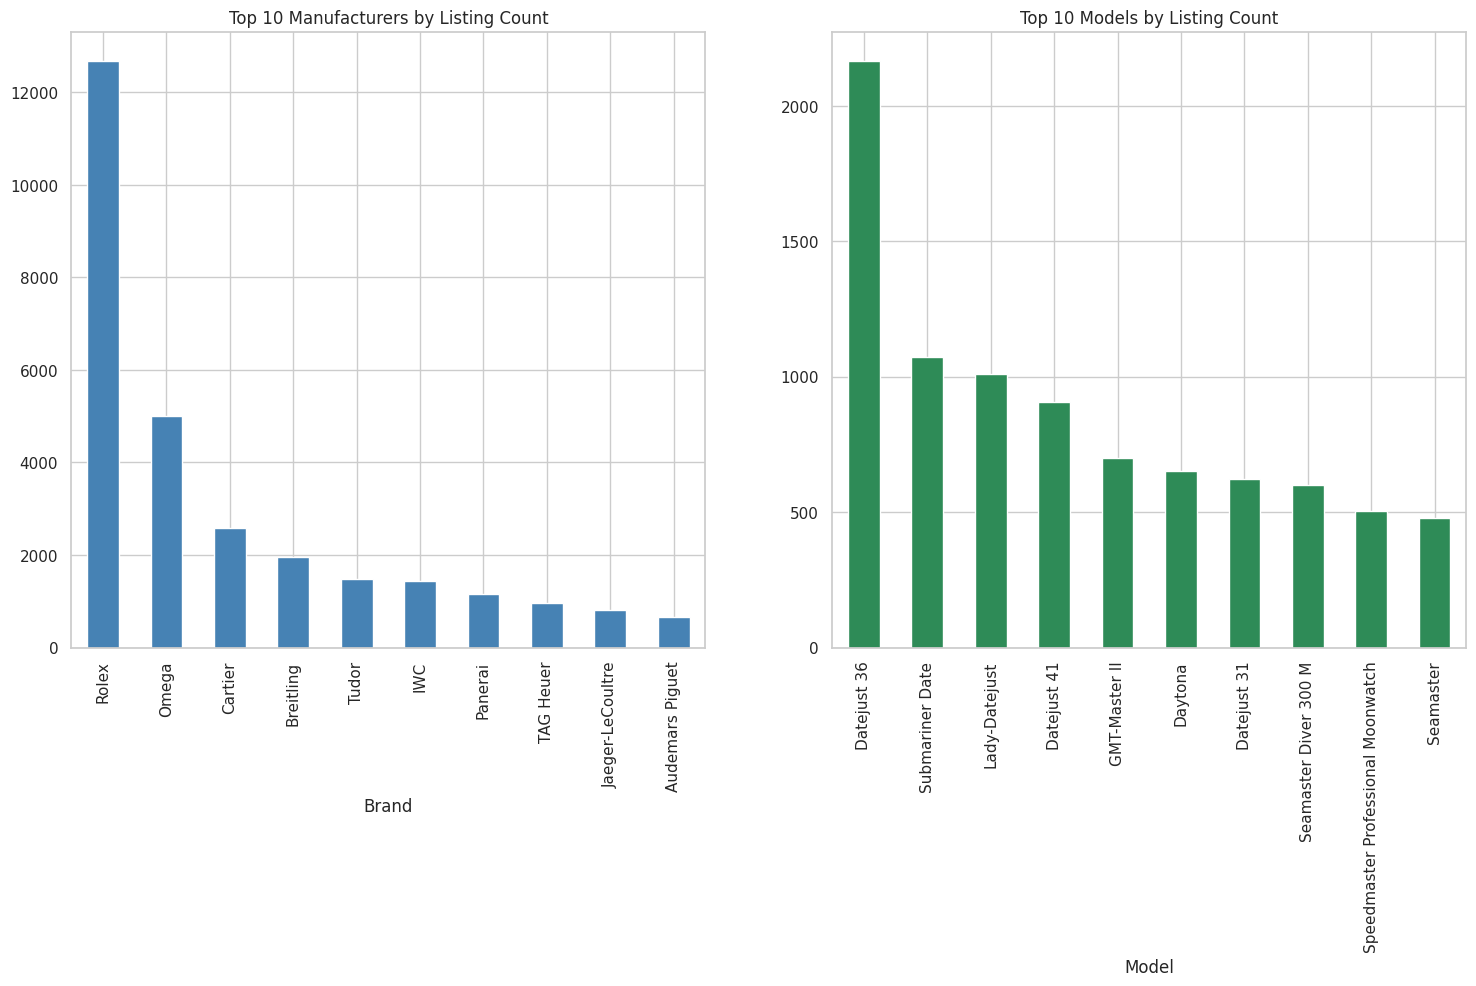

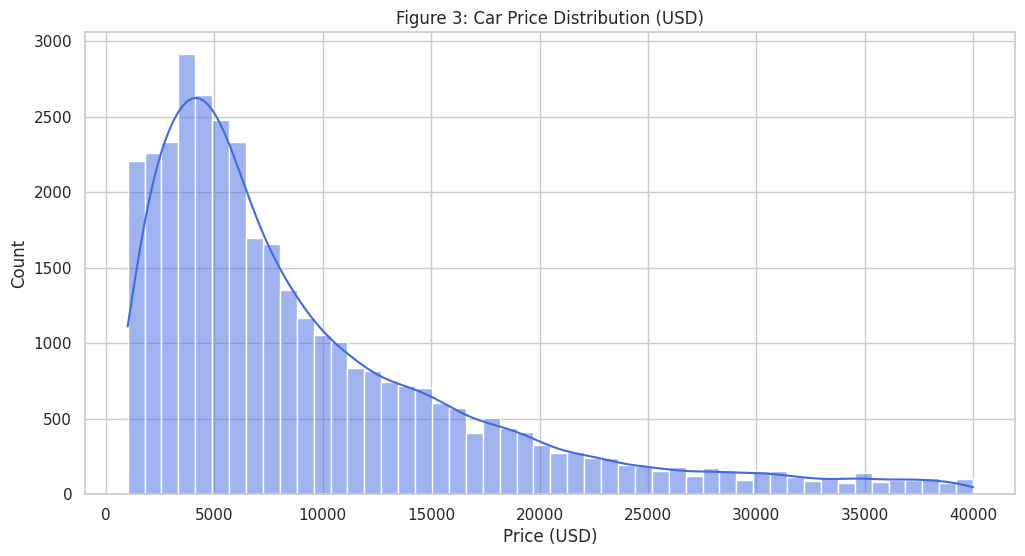

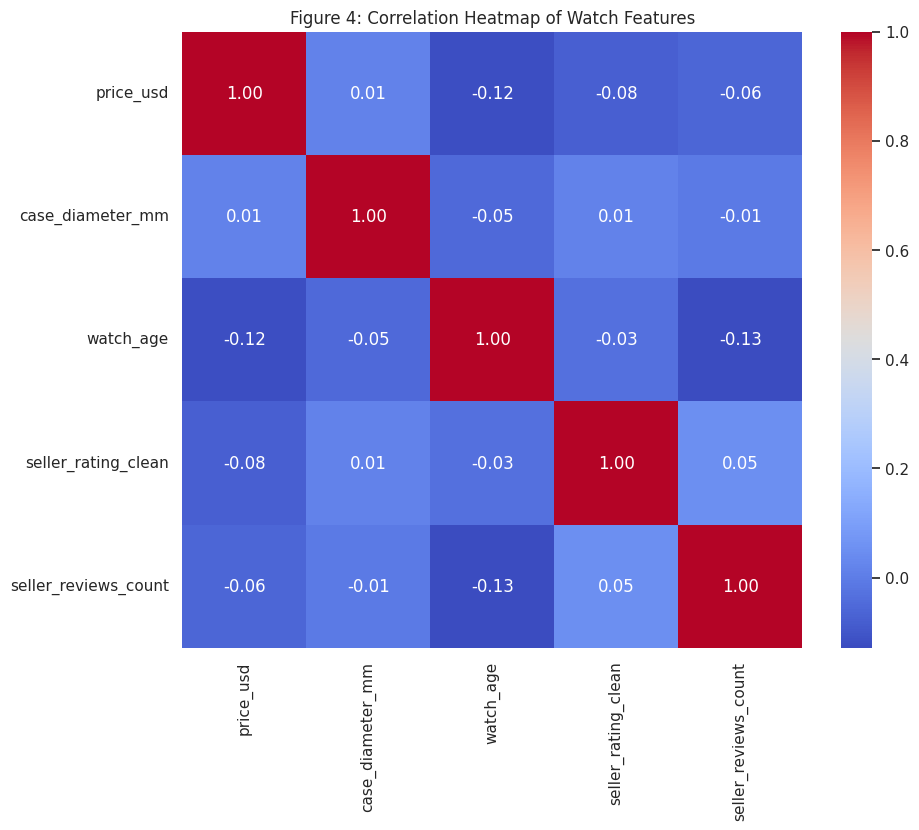

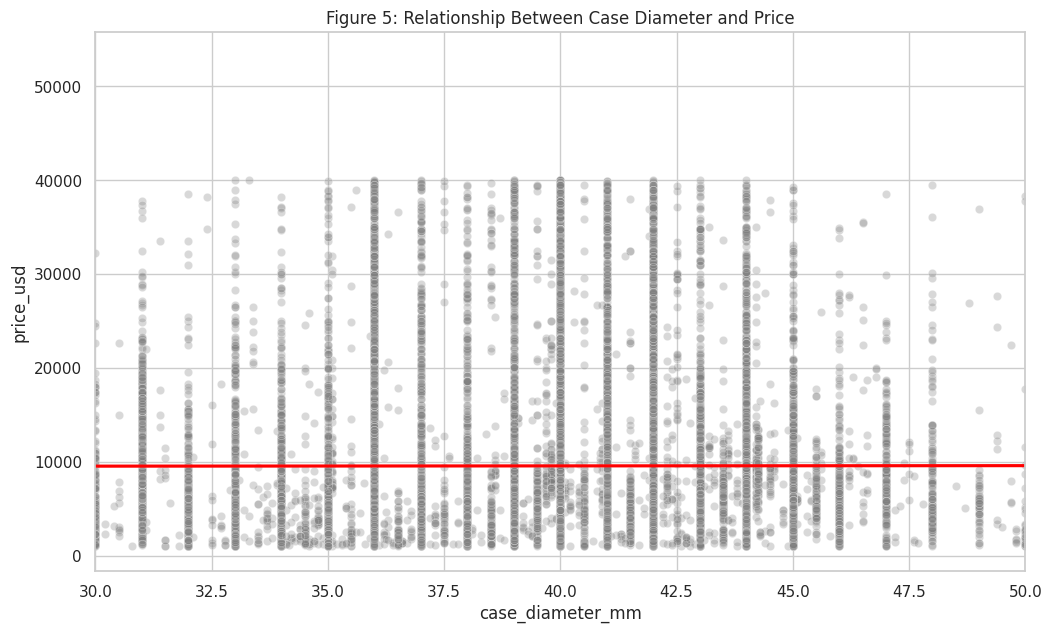

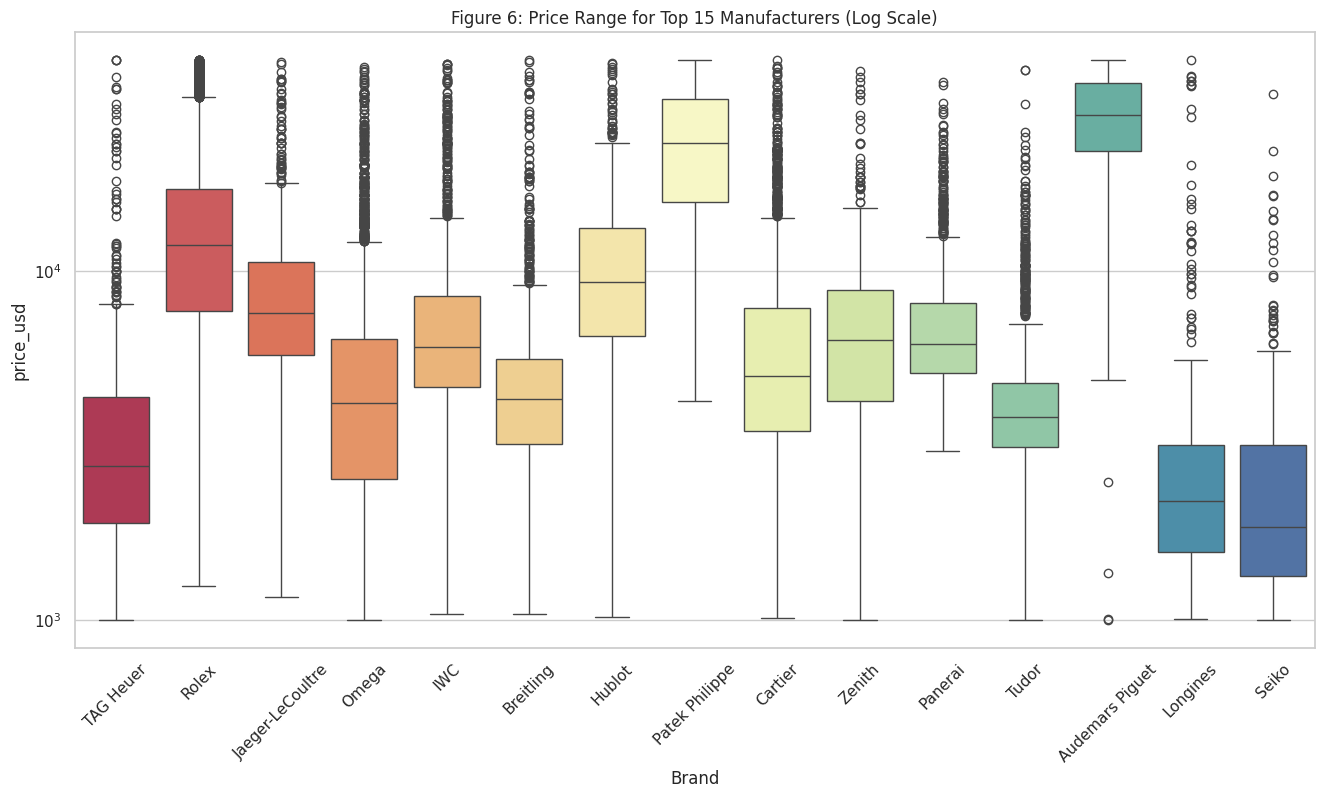

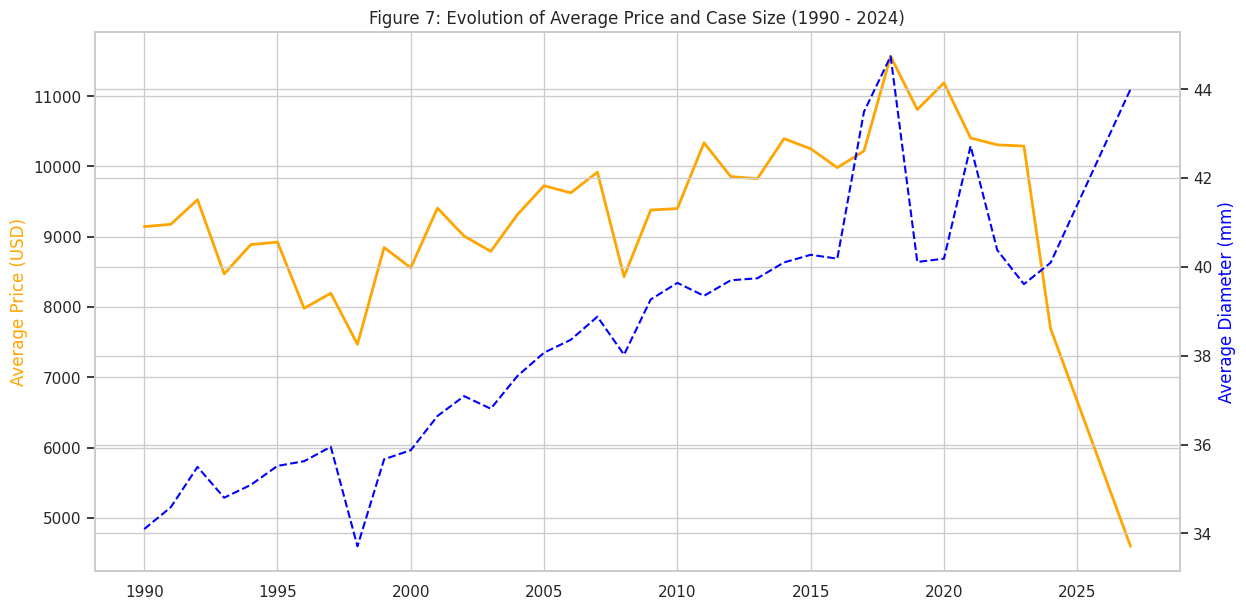

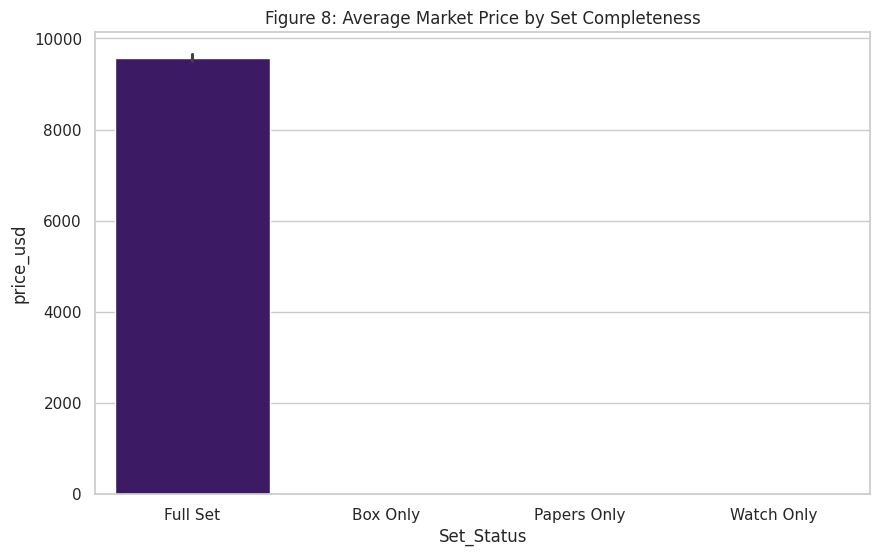

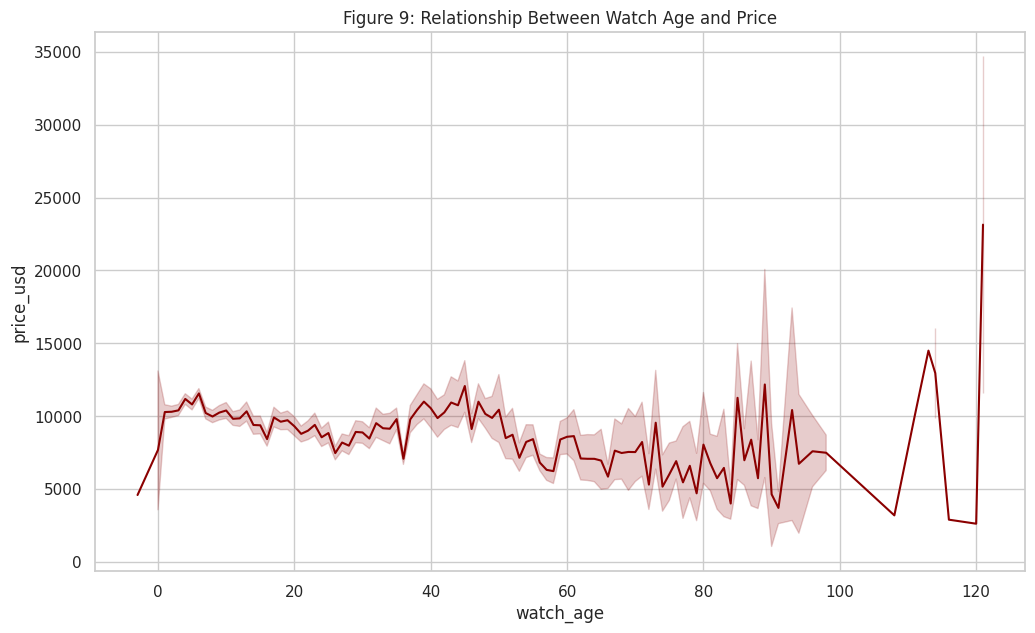

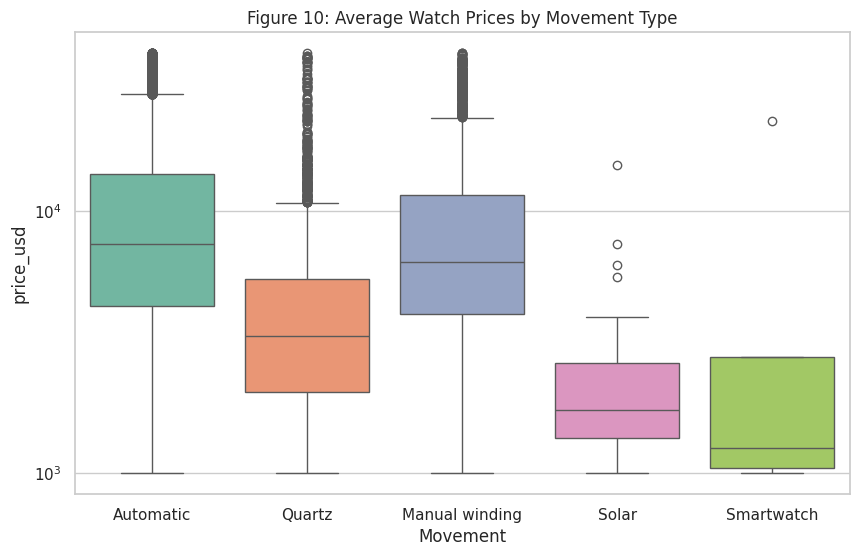

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- SETTINGS ---
INPUT_FILE = "watches_cleaned.csv"
OUTPUT_DIR = "watch_eda_report"
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

def prepare_data():
    """Clean and Engineer data for visualization."""
    df = pd.read_csv(INPUT_FILE)

    # 1. Dataset Composition (Filter) - Similar to PDF Section 2.1
    df = df[(df['price_usd'] >= 1000) & (df['price_usd'] < 40000)]
    critical_cols = ['Brand', 'Model', 'Reference number', 'case_diameter_mm', 'watch_age']
    df = df.dropna(subset=critical_cols)

    # 2. Engineering (Temporal and Categorical)
    df['production_year'] = 2024 - df['watch_age']

    # Create a "Set Completeness" feature (Inspired by PDF Optional Features)
    def determine_set(row):
        if row['has_box'] and row['has_papers']: return "Full Set"
        if row['has_box']: return "Box Only"
        if row['has_papers']: return "Papers Only"
        return "Watch Only"

    df['Set_Status'] = df.apply(determine_set, axis=1)

    # Age categories (Inspired by PDF logic)
    df['Era'] = pd.cut(df['watch_age'],
                       bins=[-1, 5, 20, 50, 150],
                       labels=['Modern (<5y)', 'Recent (5-20y)', 'Neo-Vintage (20-50y)', 'Vintage (50y+)'])

    return df

def run_full_eda(df):
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
    print(f"--- Starting EDA Report: Data contains {df.shape[0]} samples and {df.shape[1]} features ---")

    # 1. Firm vs Private Sales (Inspired by PDF 2.2.1)
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Seller type', palette='viridis')
    plt.title('Figure 1: Comparison of Watches Sold by Firms vs Private Sellers')
    plt.savefig(f"{OUTPUT_DIR}/1_seller_distribution.png")

    # 2. Top Manufacturers and Models (Inspired by PDF 2.2.2)
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    df['Brand'].value_counts().head(10).plot(kind='bar', ax=ax[0], color='steelblue')
    ax[0].set_title('Top 10 Manufacturers by Listing Count')
    df['Model'].value_counts().head(10).plot(kind='bar', ax=ax[1], color='seagreen')
    ax[1].set_title('Top 10 Models by Listing Count')
    plt.savefig(f"{OUTPUT_DIR}/2_top_brands_models.png")

    # 3. Watch Price Distribution (Inspired by PDF 2.2.3)
    plt.figure(figsize=(12, 6))
    sns.histplot(df['price_usd'], bins=50, kde=True, color='royalblue')
    plt.title('Figure 3: Car Price Distribution (USD)')
    plt.xlabel('Price (USD)')
    plt.savefig(f"{OUTPUT_DIR}/3_price_distribution.png")

    # 4. Correlation Heatmap (Inspired by PDF 2.2.4)
    plt.figure(figsize=(10, 8))
    numeric_cols = ['price_usd', 'case_diameter_mm', 'watch_age', 'seller_rating_clean', 'seller_reviews_count']
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Figure 4: Correlation Heatmap of Watch Features')
    plt.savefig(f"{OUTPUT_DIR}/4_correlation_heatmap.png")

    # 5. Case Diameter vs Price (Inspired by PDF 2.2.5 Engine Capacity vs Price)
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='case_diameter_mm', y='price_usd', alpha=0.3, color='gray')
    sns.regplot(data=df, x='case_diameter_mm', y='price_usd', scatter=False, color='red')
    plt.title('Figure 5: Relationship Between Case Diameter and Price')
    plt.xlim(30, 50) # Focus on standard sizes
    plt.savefig(f"{OUTPUT_DIR}/5_diameter_vs_price.png")

    # 6. Price Range for Each Manufacturer (Inspired by PDF 2.2.9)
    top_brands = df['Brand'].value_counts().head(15).index
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=df[df['Brand'].isin(top_brands)], x='Brand', y='price_usd', palette='Spectral')
    plt.yscale('log') # Log scale used for high-end luxury comparison
    plt.title('Figure 6: Price Range for Top 15 Manufacturers (Log Scale)')
    plt.xticks(rotation=45)
    plt.savefig(f"{OUTPUT_DIR}/6_price_ranges_by_brand.png")

    # 7. Evolution of Size and Price by Year (Inspired by PDF 2.2.13 & 2.2.17)
    fig, ax1 = plt.subplots(figsize=(14, 7))
    yearly_stats = df[df['production_year'] >= 1990].groupby('production_year').agg({'price_usd':'mean', 'case_diameter_mm':'mean'})

    ax1.plot(yearly_stats.index, yearly_stats['price_usd'], color='orange', label='Avg Price', linewidth=2)
    ax1.set_ylabel('Average Price (USD)', color='orange')

    ax2 = ax1.twinx()
    ax2.plot(yearly_stats.index, yearly_stats['case_diameter_mm'], color='blue', label='Avg Diameter', linestyle='--')
    ax2.set_ylabel('Average Diameter (mm)', color='blue')

    plt.title('Figure 7: Evolution of Average Price and Case Size (1990 - 2024)')
    plt.savefig(f"{OUTPUT_DIR}/7_temporal_evolution.png")

    # 8. Set Completeness & Price (Inspired by PDF 2.2.10 Optional Features)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Set_Status', y='price_usd', order=['Full Set', 'Box Only', 'Papers Only', 'Watch Only'], palette='magma')
    plt.title('Figure 8: Average Market Price by Set Completeness')
    plt.savefig(f"{OUTPUT_DIR}/8_completeness_impact.png")

    # 9. Mileage vs Price (Inspired by PDF 2.2.14 Kilometers vs Price)
    # In watches, 'Mileage' is 'Watch Age'
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df, x='watch_age', y='price_usd', color='darkred')
    plt.title('Figure 9: Relationship Between Watch Age and Price')
    plt.savefig(f"{OUTPUT_DIR}/9_age_depreciation.png")

    # 10. Average Price by Movement (Inspired by PDF 2.2.18 Transmission Type)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Movement', y='price_usd', palette='Set2')
    plt.yscale('log')
    plt.title('Figure 10: Average Watch Prices by Movement Type')
    plt.savefig(f"{OUTPUT_DIR}/10_movement_prices.png")

    print(f"EDA Complete. All plots are in the '{OUTPUT_DIR}' folder.")

if __name__ == "__main__":
    cleaned_df = prepare_data()
    run_full_eda(cleaned_df)

    # Output basic summary stats for the report
    print("\n--- Summary Statistics ---")
    print(cleaned_df[['price_usd', 'case_diameter_mm', 'watch_age']].describe().round(2))

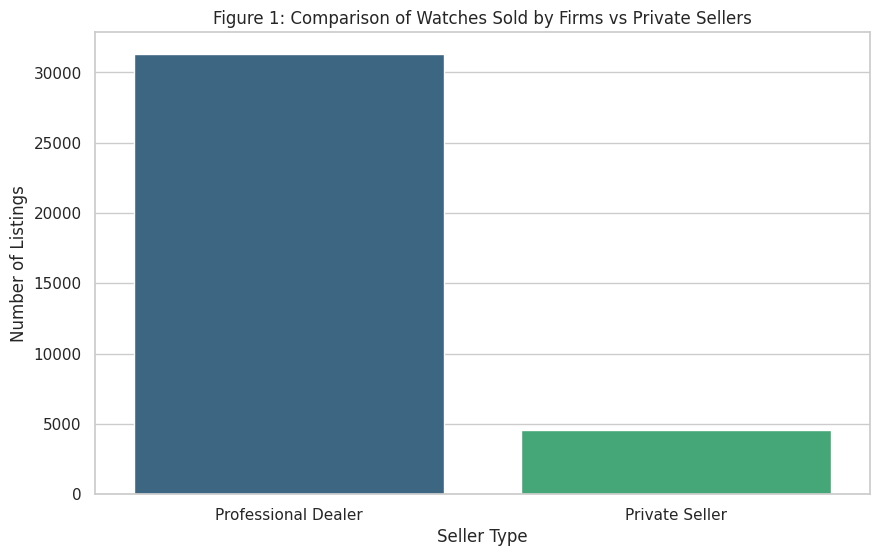

In [24]:
# Create a cleaner category for the plot
def categorize_seller(x):
    if 'private' in str(x).lower():
        return 'Private Seller'
    else:
        return 'Professional Dealer'

cleaned_df = prepare_data()

cleaned_df['Seller_Category'] = cleaned_df['Seller type'].apply(categorize_seller)

# Plot the new category
plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_df, x='Seller_Category', palette='viridis')
plt.title('Figure 1: Comparison of Watches Sold by Firms vs Private Sellers')
plt.ylabel('Number of Listings')
plt.xlabel('Seller Type')
plt.savefig(f"{OUTPUT_DIR}/1_seller_distribution.png")

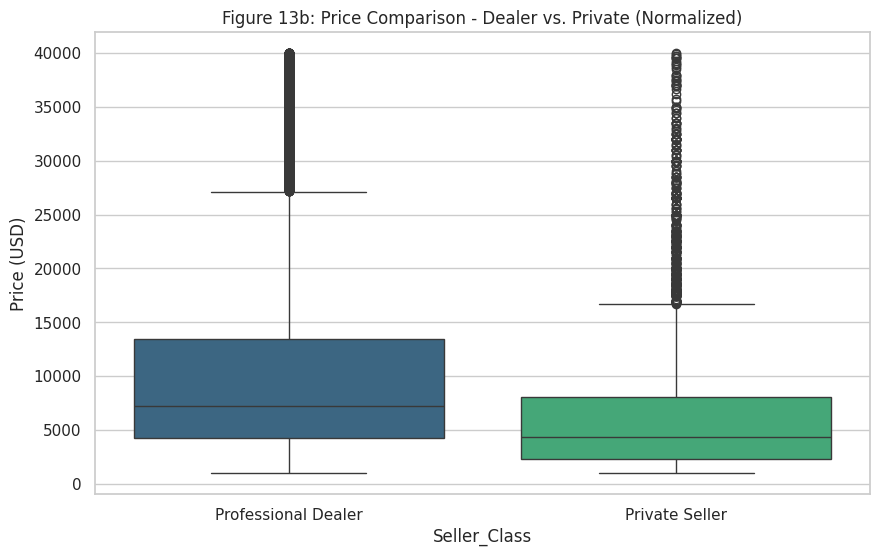

In [30]:
plt.figure(figsize=(10, 6))
# This compares the 'Typical' price of both types regardless of count
sns.boxplot(data=cleaned_df, x='Seller_Class', y='price_usd', palette='viridis')
plt.title('Figure 13b: Price Comparison - Dealer vs. Private (Normalized)')
plt.ylabel('Price (USD)')
plt.savefig(f"{OUTPUT_DIR}/13b_price_comparison_box.png")

<Figure size 1200x700 with 0 Axes>

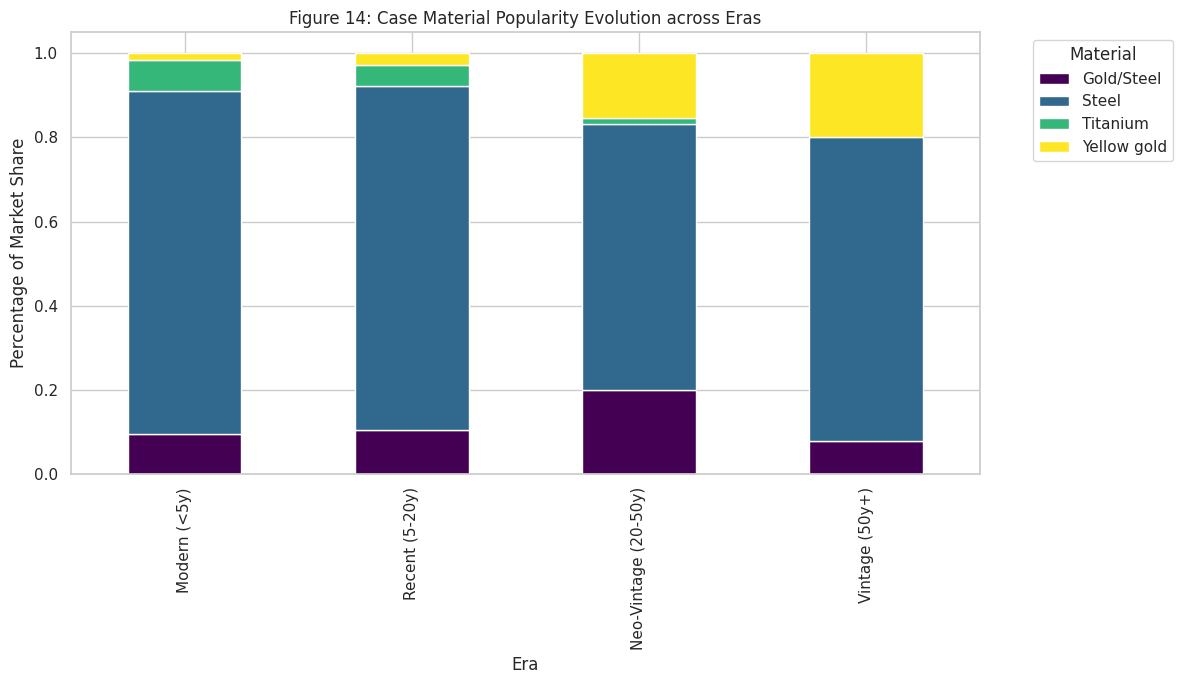

In [27]:
plt.figure(figsize=(12, 7))
# Focus on top 4 materials to keep it clean
top_mats = cleaned_df['Case material'].value_counts().head(4).index
mat_trend = cleaned_df[cleaned_df['Case material'].isin(top_mats)]

# Create a cross-tabulation of Era vs Material
ct = pd.crosstab(mat_trend['Era'], mat_trend['Case material'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))

plt.title('Figure 14: Case Material Popularity Evolution across Eras')
plt.ylabel('Percentage of Market Share')
plt.legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/14_material_trends.png")